In [30]:
import os 
import shutil
import zipfile
import sklearn
import graphviz 
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.metrics import accuracy_score, recall_score, precision_recall_curve, confusion_matrix 
from sklearn.tree import DecisionTreeClassifier, export_graphviz 

In [2]:
file_name = "E:\\workSpace_Dataset\\UCI HAR Dataset.zip"
EXTRACT_DIR = "E:\\workSpace_Dataset\\UCI"
ACRHIVE_FORMAT = "zip"

shutil.unpack_archive(file_name, EXTRACT_DIR, ACRHIVE_FORMAT)

In [3]:
df_feature_name = pd.read_csv("E:\\workSpace_Dataset\\UCI\\UCI HAR Dataset\\features.txt", sep="\s+", header=None, names=['column_index','column_name'])

In [4]:
df_feature_duplicate = df_feature_name.groupby("column_name").count()
df_feature_duplicate

,column_index
column_name,
"angle(X,gravityMean)",1
"angle(Y,gravityMean)",1
"angle(Z,gravityMean)",1
"angle(tBodyAccJerkMean),gravityMean)",1
"angle(tBodyAccMean,gravity)",1
...,...
tGravityAccMag-max(),1
tGravityAccMag-mean(),1
tGravityAccMag-min(),1


In [7]:
print(df_feature_duplicate[df_feature_duplicate["column_index"] > 1].count())
df_feature_duplicate[df_feature_duplicate["column_index"]> 1].head(10)

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3
"fBodyAcc-bandsEnergy()-25,32",3
"fBodyAcc-bandsEnergy()-25,48",3
"fBodyAcc-bandsEnergy()-33,40",3
"fBodyAcc-bandsEnergy()-33,48",3


In [19]:
def get_new_feature_name(df_old_feature_name):
    df_feature_duplicate = pd.DataFrame(data=df_old_feature_name.groupby("column_name").cumcount(), columns=["duplicate_cnt"])
    df_feature_duplicate = df_feature_duplicate.reset_index()
    df_new_feature_name = pd.merge(df_old_feature_name.reset_index(), df_feature_duplicate, how="outer")
    df_new_feature_name["column_name"] = df_new_feature_name[["column_name", "duplicate_cnt"]].apply(lambda x : x[0] + "_" +str(x[1]) if x[1]>0 else x [0], axis=1)
   
    
    df_new_feature_name = df_new_feature_name.drop(["index"], axis=1)
    return df_new_feature_name
    

In [20]:
def get_human_dataset():
    df_feature_name = pd.read_csv("E:\\workSpace_Dataset\\UCI\\UCI HAR Dataset\\features.txt", sep="\s+", header=None, names=['column_index','column_name'])
    df_new_feature_name = get_new_feature_name(df_feature_name) 
    feature_name = df_new_feature_name.iloc[:, 1].values.tolist()
   
    X_train = pd.read_csv("E:\\workSpace_Dataset\\UCI\\UCI HAR Dataset\\train\\X_train.txt", sep="\s+", names = feature_name)
    X_test = pd.read_csv("E:\\workSpace_Dataset\\UCI\\UCI HAR Dataset\\test\\X_test.txt", sep="\s+", names = feature_name)
   
    y_train = pd.read_csv("E:\\workSpace_Dataset\\UCI\\UCI HAR Dataset\\train\\y_train.txt",sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv("E:\\workSpace_Dataset\\UCI\\UCI HAR Dataset\\test\\y_test.txt",sep='\s+',header=None,names=['action'])
   
    return X_train, X_test, y_train, y_test 


In [21]:
X_train, X_test, y_train, y_test = get_human_dataset()


In [23]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7352, 561)
(2947, 561)
(7352, 1)
(2947, 1)


In [26]:
print(y_train["action"].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


In [28]:
dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
predict_result = dt_clf.predict(X_test)
print(type(predict_result))
accuracy = accuracy_score(y_test, predict_result)
print("Predictuve Accuracy of  Decision Tree {0:.4f}".format(accuracy))

<class 'numpy.ndarray'>
Predictuve Accuracy of  Decision Tree 0.8548


In [29]:
print("Decision Tree Basic Parameter\n", dt_clf.get_params())

Decision Tree Basic Parameter
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


In [31]:
params = {"max_depth": [6, 8, 10, 12, 16, 20, 24],
          "min_samples_split":[16]}

In [33]:
grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring="accuracy", cv=5, verbose=1)
grid_cv.fit(X_train, y_train) 
print("GridSearCV Best Average Accuracy {0:.4f}".format(grid_cv.best_score_))
print("GridSearchCV Best Hypter Parameter ", grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearCV Best Average Accuracy 0.8549
GridSearchCV Best Hypter Parameter  {'max_depth': 8, 'min_samples_split': 16}


In [35]:
df_cv_result = pd.DataFrame(grid_cv.cv_results_)

df_cv_result [["param_max_depth", "mean_test_score"]]

,param_max_depth,mean_test_score
0,6,0.847662
1,8,0.854879
2,10,0.852705
3,12,0.845768
4,16,0.847127
5,20,0.848624
6,24,0.848624


In [36]:
df_cv_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.650257,0.061302,0.009573,0.004746,6,16,"{'max_depth': 6, 'min_samples_split': 16}",0.813732,0.868117,0.819728,0.866667,0.870068,0.847662,0.025350,5
1,2.058015,0.019808,0.006580,0.000800,8,16,"{'max_depth': 8, 'min_samples_split': 16}",0.806254,0.830048,0.860544,0.874830,0.902721,0.854879,0.033764,1
2,2.778256,0.416653,0.006775,0.000755,10,16,"{'max_depth': 10, 'min_samples_split': 16}",0.804895,0.816451,0.866667,0.884354,0.891156,0.852705,0.035427,2
3,2.861658,0.343724,0.007974,0.002542,12,16,"{'max_depth': 12, 'min_samples_split': 16}",0.798097,0.810333,0.851020,0.884354,0.885034,0.845768,0.036295,7
4,3.660585,0.850031,0.006382,0.000489,16,16,"{'max_depth': 16, 'min_samples_split': 16}",0.800816,0.815092,0.858503,0.876871,0.884354,0.847127,0.033379,6
5,3.247701,0.283137,0.006589,0.000810,20,16,"{'max_depth': 20, 'min_samples_split': 16}",0.798097,0.815092,0.858503,0.876871,0.894558,0.848624,0.036559,3
6,3.773302,0.549281,0.009578,0.002782,24,16,"{'max_depth': 24, 'min_samples_split': 16}",0.798097,0.815092,0.858503,0.876871,0.894558,0.848624,0.036559,3


In [37]:
lst_max_depth  = [6, 8, 10, 12, 16, 18, 20, 22, 24]

for depth in lst_max_depth : 
    dt_clf = DecisionTreeClassifier(max_depth=depth, min_samples_split=16, random_state=156)
    dt_clf.fit(X_train, y_train)
    predict = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test, predict)
    print("Max Depth {0} Accuracy {1:.4f}".format(depth, accuracy))

Max Depth 6 Accuracy 0.8551
Max Depth 8 Accuracy 0.8717
Max Depth 10 Accuracy 0.8599
Max Depth 12 Accuracy 0.8571
Max Depth 16 Accuracy 0.8599
Max Depth 18 Accuracy 0.8565
Max Depth 20 Accuracy 0.8565
Max Depth 22 Accuracy 0.8565
Max Depth 24 Accuracy 0.8565


In [39]:
params = {"max_depth" :[4, 8, 12, 16, 20 , 24 ], 
          "min_samples_split" : [16, 24]}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring="accuracy", cv=5, verbose=1)
grid_cv.fit(X_train, y_train)





Fitting 5 folds for each of 12 candidates, totalling 60 fits
GridSearchCV Best Average accuracy value : 0.8549
GridSearchCV Best Hyper Paramter : {'max_depth': 8, 'min_samples_split': 16}


In [40]:
print("GridSearchCV Best Average accuracy value : {0:.4f}".format(grid_cv.best_score_))
print("GridSearchCV Best Hyper Paramter : {0}".format(grid_cv.best_params_))

GridSearchCV Best Average accuracy value : 0.8549
GridSearchCV Best Hyper Paramter : {'max_depth': 8, 'min_samples_split': 16}


In [44]:
best_dt_clf = grid_cv.best_estimator_ 
best_prediction = best_dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, best_prediction)
print("Accuracy : {0:.4f}".format(accuracy))

Accuracy : 0.8717


In [46]:
ftr_importance

tBodyAcc-mean()-X                       0.000000
tBodyAcc-mean()-Y                       0.000000
tBodyAcc-mean()-Z                       0.000000
tBodyAcc-std()-X                        0.000000
tBodyAcc-std()-Y                        0.001752
                                          ...   
angle(tBodyGyroMean,gravityMean)        0.001291
angle(tBodyGyroJerkMean,gravityMean)    0.000000
angle(X,gravityMean)                    0.000989
angle(Y,gravityMean)                    0.139001
angle(Z,gravityMean)                    0.002987
Length: 561, dtype: float64

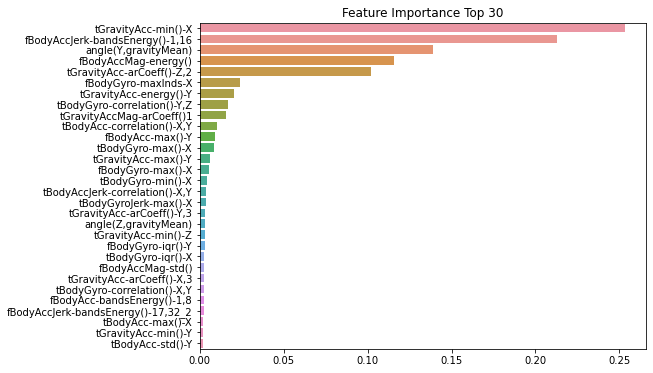

In [48]:
ftr_importance_values = best_dt_clf.feature_importances_

ftr_importance = pd.Series(ftr_importance_values, index = X_train.columns)

ftr_top20 = ftr_importance.sort_values(ascending=False)[:30]
plt.figure(figsize=(8, 6))
plt.title("Feature Importance Top 30")
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()